# Sentiment Analiza korišćenjem Naive Bayes klasifikatora na recenzije GTX1060 grafičke kartice

###  Obavljeni koraci
 1.  Scrape-ovani podaci sa Interneta korišćenjem BeautifulSoup
 2.  Tokenizovali recenzije korišćenjem NLTK
 3.  Kategorizovali recenzije u pozitivne i negativne korišćenjem Bing Lexicon kao referencu
 4.  Ekstraktovali karakteristike i sentiment iz recenzija
 5.  Koristili Naive Bayes klasifikator da predvidi sentiment test podataka 
 6.  Kalkulisali preciznos klasifikatora


In [28]:
#Importovanje potrebnih biblioteka
import urllib
from urllib.request import urlopen
from bs4 import BeautifulSoup
import pandas as pd
import nltk
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import lxml


%matplotlib inline
from nltk.corpus import stopwords
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split




## Scrape-ovanje podataka sa interneta korišćenjem BeautifulSoup

In [31]:
#Scrape-ovanje recenzija sa NewEgg-a
data = []
for i in range(1,250):
    
    re = requests.get("https://www.newegg.com/evga-geforce-gtx-1060-06g-p4-6163-kr/p/N82E16814487261".format(i))
    soup = BeautifulSoup(re.content)
    
    x = soup.find_all("div", {"class":"comments-cell has-side-left is-active"})
    for item in x:
        author_name =item.find_all("div",attrs = {"class":"comments-name"})[0].text
        rating = item.find_all("span",attrs={"itemprop":"ratingValue"})[0].text
        review_title = item.find_all("span",attrs={"class":"comments-title-content"})[0].text
        review_description = item.find_all("div",attrs={"class":"comments-content"})[0].text
        data.append((author_name,rating, review_title,review_description ))
        
        
        

In [32]:
#Učitavanje recenzija u dataframe korišćenjem Pandas
reviews_df= pd.DataFrame(data)
reviews_df.columns = ["Review_Author","Review_Rating","Review_Title","Review_Description"]

In [33]:
reviews_df.head()

,Review_Author,Review_Rating,Review_Title,Review_Description
0,Anonymous,5,Good value card,\n\nPros:\r\n -Runs most games ...
1,Anonymous,1,EVGA and their rebate company is garbage.,\n\nPros:\r\n Nothing\r\n ...
2,Anonymous,2,Loud,"\n\nPros:\r\n works great,cheap..."
3,Anonymous,5,Fire,"\n\nPros:\r\n It's a nice ""budg..."
4,Anonymous,5,Great video card,\n\nPros:\r\n -awesome performa...


In [34]:
def isNotNull(value):
    return value is not None and len(value)>0

In [35]:
os.chdir('C:\\Users\\Bogdan\\Desktop\\opinion-lexicon-English\\')
dict_pos = []
dict_neg = []
f = open('negative-words.txt','r')
for line in f:
    t= line.strip().lower()
    if (isNotNull(t)):
           dict_neg.append(t)
f.close()

f = open('positive-words.txt','r')
for line in f:
    t = line.strip().lower();
    if (isNotNull(t)):
        dict_pos.append(t)
f.close()

In [36]:
del dict_pos[0:34]
del dict_neg[0:34]

## Tokenizovanje recenzija korišćenjem NLTK

In [38]:
list = []

positive_count_summary_list = []
positive_summary_count= []

positive_words_list = []

negative_count_summary_list = []
negative_summary_count =[]

negative_words_list = []

appended_data = pd.DataFrame([])
sentiment_summary_list = []

stopwords_set = set(stopwords.words("english"))

for index, row in reviews_df.iterrows():
    
        words_filtered = [e.lower() for e in row.Review_Description.split() if len(e) >= 3]
        words_without_stopwords = [word for word in words_filtered if not word in stopwords_set]
        
        positive_words = set(dict_pos).intersection(words_without_stopwords)
        positive_words_list.append(positive_words)
        
        positive_count = len(set(dict_pos).intersection(words_without_stopwords))
        negative_count = len(set(dict_neg).intersection(words_without_stopwords))
        
        negative_words = set(dict_neg).intersection(words_without_stopwords)
        negative_words_list.append(negative_words)

        positive_count_summary_list.append(positive_count)
        negative_count_summary_list.append(negative_count)
    
        if positive_count > negative_count:
            sentiment_summary_list.append('positive')
            

            
        elif positive_count < negative_count:
            sentiment_summary_list.append('negative')

        else:
            sentiment_summary_list.append('neutral')
        reviews_df['summary_sentiment'] = pd.DataFrame((sentiment_summary_list))
        list.append((words_without_stopwords, row.summary_sentiment))


In [39]:
reviews_df = reviews_df.assign(positive_words_count=pd.Series(positive_count_summary_list).values)
reviews_df = reviews_df.assign(negative_words_count=pd.Series(negative_count_summary_list).values)
reviews_df = reviews_df.assign(positive_words=pd.Series(positive_words_list).values)
reviews_df = reviews_df.assign(negative_words=pd.Series(negative_words_list).values)


## Kategorisanje recenzija u pozitivne i negativne korišćenjem Bing Lexicon-a

In [40]:
reviews_df.head()

,Review_Author,Review_Rating,Review_Title,Review_Description,summary_sentiment,positive_words_count,negative_words_count,positive_words,negative_words
0,Anonymous,5,Good value card,\n\nPros:\r\n -Runs most games ...,neutral,2,2,"{appropriate, worth}","{broken, decline}"
1,Anonymous,1,EVGA and their rebate company is garbage.,\n\nPros:\r\n Nothing\r\n ...,negative,0,3,{},"{messed, worse, blame}"
2,Anonymous,2,Loud,"\n\nPros:\r\n works great,cheap...",positive,3,2,"{great, works, best}","{loud, freaking}"
3,Anonymous,5,Fire,"\n\nPros:\r\n It's a nice ""budg...",positive,4,2,"{nice, well, fast, right}","{regret, problem}"
4,Anonymous,5,Great video card,\n\nPros:\r\n -awesome performa...,positive,2,1,"{flawlessly, best}",{complaints}


## Vizualizacija pozitivnih riječi u recenzijama

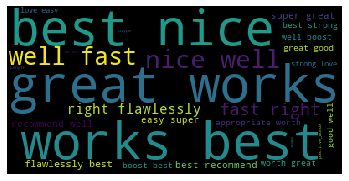

In [41]:
wordcloud = WordCloud(background_color='black',
                          max_words=800,
                          max_font_size=60, 
                          random_state=50).generate(str(reviews_df['positive_words']))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


## Vizualizacija negativnih riječi u recenzijama

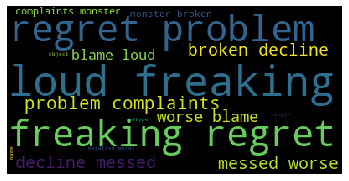

In [42]:
wordcloud = WordCloud(background_color='black',
                          max_words=800,
                          max_font_size=60, 
                          random_state=50).generate(str(reviews_df['negative_words']))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


In [43]:
reviews_df['Review_Length'] = reviews_df['Review_Description'].apply(len)

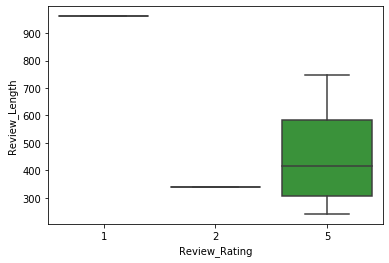

In [44]:
sns.boxplot(x='Review_Rating', y='Review_Length', data=reviews_df)

## Korelacija između ocjena i sentimenta u recenzijama

In [45]:
rating = reviews_df.groupby('Review_Rating').mean()
rating.corr()

,positive_words_count,negative_words_count,Review_Length
positive_words_count,1.000000,-0.924473,-0.954122
negative_words_count,-0.924473,1.000000,0.767909
Review_Length,-0.954122,0.767909,1.000000


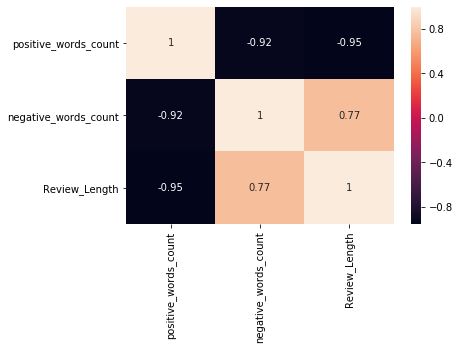

In [46]:
sns.heatmap(data=rating.corr(), annot=True)


In [47]:
df= pd.DataFrame(reviews_df[['Review_Description','summary_sentiment']])

In [48]:
df.head()

,Review_Description,summary_sentiment
0,\n\nPros:\r\n -Runs most games ...,neutral
1,\n\nPros:\r\n Nothing\r\n ...,negative
2,"\n\nPros:\r\n works great,cheap...",positive
3,"\n\nPros:\r\n It's a nice ""budg...",positive
4,\n\nPros:\r\n -awesome performa...,positive


In [49]:
df_pos = df.groupby('summary_sentiment').get_group("positive")['Review_Description']

df_neg = df.groupby('summary_sentiment').get_group("negative")['Review_Description']


## Ekstraktovanje karakteristika iz recenzija i sentimenta

In [ ]:
def get_words_in_list(list):
    all = []
    for (words, sentiment) in list:
        all.extend(words)
    return all

def get_word_features(wordlist):
    wordlist = nltk.FreqDist(wordlist)
    features = wordlist.keys()
    return features
w_features = get_word_features(get_words_in_list(list))

def extract_features(document):
    document_words = set(document)
    features = {}
    for word in w_features:
        features['contains(%s)' % word] = (word in document_words)
    return features

In [51]:
data= nltk.classify.apply_features(extract_features,list)

In [52]:
train, test = train_test_split(data,test_size = 0.2)

## Koristimo Naive Bayes klasifikator da predvidimo sentiment u test podatke

In [64]:
classifier = nltk.NaiveBayesClassifier.train(train)

## Kalkulišemo preciznost klasifikatora

In [65]:
print(nltk.classify.accuracy(classifier,test))

1.0


In [66]:
neg_cnt = 0
pos_cnt = 0
for obj in df_neg: 
    res =  classifier.classify(extract_features(obj.split()))
    if(res == 'negative'): 
        neg_cnt = neg_cnt + 1
for obj in df_pos: 
    res =  classifier.classify(extract_features(obj.split()))
    if(res == 'positive'): 
        pos_cnt = pos_cnt + 1

        
print('[Negative]: %s/%s '  % (neg_cnt,len(df_neg)))        
print('[Positive]: %s/%s '  % (pos_cnt,len(df_pos)))

[Negative]: 13/13 
[Positive]: 78/78 
